In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from matplotlib import style
style.use('fivethirtyeight')

In [2]:
path = 'kaggle/input/'
file_name = 'bitstampUSD_1-min_data_2012-01-01_to_2020-12-31.csv'
full_path = path + file_name
bitcoinData = pd.read_csv(full_path)

bitcoinData.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# renaming columns of dataset
bitcoinData = bitcoinData.rename(columns = {
    'Volume_(BTC)':'VolumeBTC',
    'Volume_(Currency)':'VolumeCurrency',
    'Weighted_Price':'WeightedPrice'
})

# convert Timestamp to a date
bitcoinData['Timestamp'] = pd.to_datetime( bitcoinData['Timestamp'], unit = 's' )

# remove rows with null values from the dataframe
bitcoinData = bitcoinData.dropna(how='all', subset=['Open','High','Low','Close','WeightedPrice'])
print('Dataframe rows after dropping null values:', bitcoinData.shape[0])
bitcoinData.tail(15)

Dataframe rows after dropping null values: 3484305


,Timestamp,Open,High,Low,Close,VolumeBTC,VolumeCurrency,WeightedPrice
4727762,2020-12-30 23:46:00,28880.00,28894.20,28867.14,28886.15,6.004953,173422.674680,28879.940696
4727763,2020-12-30 23:47:00,28883.69,28899.84,28877.23,28880.39,0.935234,27013.439712,28884.159258
4727764,2020-12-30 23:48:00,28871.54,28877.63,28831.16,28844.48,0.889523,25669.318596,28857.404737
4727765,2020-12-30 23:49:00,28844.56,28853.38,28809.24,28809.24,1.517480,43761.571934,28838.324830
4727766,2020-12-30 23:50:00,28816.76,28842.41,28800.00,28836.97,0.209298,6033.945519,28829.425958
4727767,2020-12-30 23:51:00,28836.97,28849.67,28807.78,28826.52,2.051917,59173.965272,28838.376450
4727768,2020-12-30 23:52:00,28826.49,28844.25,28816.09,28816.09,0.721410,20803.457100,28837.207539
4727769,2020-12-30 23:53:00,28814.36,28822.71,28800.00,28800.00,1.529671,44076.572351,28814.411945
4727770,2020-12-30 23:54:00,28800.00,28832.79,28800.00,28831.35,2.036450,58675.679644,28812.732950
4727771,2020-12-30 23:55:00,28809.07,28825.50,28800.01,28810.08,0.087391,2517.799582,28810.597267


In [4]:
# no remaining null values in any column for any row
bitcoinData.isnull().any()

Timestamp         False
Open              False
High              False
Low               False
Close             False
VolumeBTC         False
VolumeCurrency    False
WeightedPrice     False
dtype: bool

In [5]:
# Function to get the label every row by the hour, i.e. it drops the minute and seconds from Timestamp
def getHour(dt):
    s = str(dt.year) + '-' + str(dt.month) + '-' + str(dt.day) + ' ' + str(dt.hour)
    return datetime.strptime(s, '%Y-%m-%d %H')

bitcoinData['Hour'] = bitcoinData['Timestamp'].apply(getHour)

In [6]:
#Calculate hourly open and close prices
hourOpen = pd.DataFrame(bitcoinData.groupby(['Hour'])['Timestamp'].min())
hourClose = pd.DataFrame(bitcoinData.groupby(['Hour'])['Timestamp'].max())
hourOpen = pd.merge(hourOpen, bitcoinData[['Hour','Timestamp','Open']], how='left', on=['Hour','Timestamp']).drop(['Timestamp'], axis=1)
hourClose = pd.merge(hourClose, bitcoinData[['Hour','Timestamp','Open']], how='left', on=['Hour','Timestamp']).drop(['Timestamp'], axis=1)

# Merge hourly open and close prices into hourlyData DataFrame 
hourlyData = pd.merge(hourOpen, hourClose, how='inner', on=['Hour'])
hourlyData = hourlyData.rename(columns={'Open_x':'Open', 'Open_y':'Close'})

# set the 'Hour' column as the index
hourlyData = hourlyData.set_index('Hour')



In [7]:
# define function to calculate hourly average price weighted by volume
def hourlyWeightAvg(hourGroup, volCol, wPriceCol):
    vol = hourGroup[volCol]
    price = hourGroup[wPriceCol]
    
    return ((vol * price).sum())/(vol.sum())

# find the high and low price for each hour
hourlyData['High'] = bitcoinData.groupby(['Hour'])['High'].max()
hourlyData['Low'] = bitcoinData.groupby(['Hour'])['Low'].min()

# The volume for an hour is the sum of trade volume for each minute in the hour
hourlyData['VolumeBTC'] = bitcoinData.groupby(['Hour'])['VolumeBTC'].sum()
hourlyData['VolumeCurrency'] = bitcoinData.groupby(['Hour'])['VolumeCurrency'].sum()

# Calculate the weighted average for each hour
hourlyData['WeightedHourAvg'] = bitcoinData.groupby(['Hour']).apply(hourlyWeightAvg, 'VolumeBTC', 'WeightedPrice')
hourlyData = hourlyData.reset_index()

hourlyData.tail(10)

,Hour,Open,Close,High,Low,VolumeBTC,VolumeCurrency,WeightedHourAvg
75364,2020-12-30 15:00:00,28193.92,28144.00,28290.00,28025.37,316.952464,8.922800e+06,28151.855925
75365,2020-12-30 16:00:00,28160.90,28111.00,28232.10,27896.34,457.983947,1.286516e+07,28090.842790
75366,2020-12-30 17:00:00,28150.92,28246.33,28328.68,28050.00,422.149256,1.190804e+07,28208.132527
75367,2020-12-30 18:00:00,28259.01,28509.71,28534.08,28246.00,595.872076,1.692029e+07,28395.848192
75368,2020-12-30 19:00:00,28523.16,28798.65,28917.39,28465.73,1213.070914,3.487729e+07,28751.241026
75369,2020-12-30 20:00:00,28807.89,28834.83,29010.32,28605.54,758.997803,2.186878e+07,28812.704316
75370,2020-12-30 21:00:00,28789.77,28897.27,29008.00,28510.00,474.773822,1.367532e+07,28803.855291
75371,2020-12-30 22:00:00,28896.96,28760.94,28942.32,28602.61,237.251362,6.832905e+06,28800.276645
75372,2020-12-30 23:00:00,28731.27,28910.54,28936.93,28643.32,142.471053,4.105594e+06,28817.041394
75373,2020-12-31 00:00:00,28893.21,28893.21,28928.49,28893.21,5.757679,1.664497e+05,28909.166061


In [8]:
# define a scaler to scale the date
normalizer = MinMaxScaler(feature_range=(0,1))

# scale the data
scaledData= normalizer.fit_transform(hourlyData[
    ['Open','High','Low','Close','VolumeBTC','WeightedHourAvg',]].values)

In [15]:
# Create test and validation sets
# Here the test and validation sets use 24-hour steps. So although the data is 
# broken into hours the models here will still be predicting daily prices. The input blocks are
# 72 hours long. The validation set is the last year of the historical data running from January 1, 2020 
# until December 31, 2020

X=[]
Y=[]

for i in range(72,len(scaledData)-24, 24):
        X.append(np.array(scaledData[i-72:i+1]).flatten())
        Y.append(scaledData[i+24,1])
        
testSize = 365

XDense_train = np.array(X[:len(X)-testSize])
XDense_test = np.array(X[len(X)-testSize:])
YDense_train = np.array(Y[:len(Y)-testSize])
YDense_test = np.array(Y[len(Y)-testSize:])

assert (len(XDense_train)==len(YDense_train))
assert (len(XDense_test)==len(YDense_test))

XDense_train.shape

(2772, 438)

In [113]:
# Create a fully connected Dense NN
denseNN = keras.Sequential()

denseNN.add(keras.layers.Input(XDense_train.shape[1]))
denseNN.add(keras.layers.Dense(units = 2048, activation='relu'))
denseNN.add(keras.layers.Dropout(0.4))
denseNN.add(keras.layers.Dense(units = 2048, activation='relu'))
denseNN.add(keras.layers.Dropout(0.4))
denseNN.add(keras.layers.Dense(units = 1024, activation='relu'))
denseNN.add(keras.layers.Dropout(0.4))
denseNN.add(keras.layers.Dense(units = 512, activation='relu'))
denseNN.add(keras.layers.Dropout(0.4))
denseNN.add(keras.layers.Dense(units = 256, activation='relu'))
denseNN.add(keras.layers.Dropout(0.4))
denseNN.add(keras.layers.Dense(units = 128, activation='relu'))
denseNN.add(keras.layers.Dropout(0.4))
denseNN.add(keras.layers.Dense(units = 64, activation='relu'))
denseNN.add(keras.layers.Dropout(0.4))
denseNN.add(keras.layers.Dense(units=1))

denseNN.compile(optimizer='adam', loss='mean_squared_error')

denseNN.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 2048)              899072    
_________________________________________________________________
dropout_66 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_60 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dropout_67 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_61 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_68 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_62 (Dense)             (None, 512)             

In [95]:
saveModel = keras.callbacks.ModelCheckpoint(filepath ='./HourDense1', monitor='val_loss', mode='min', save_best_only=True)
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20)

#train the model
denseNN.fit(XDense_train, YDense_train, epochs=300,
           validation_data=(XDense_test, YDense_test), callbacks=[saveModel, earlyStopping])


Epoch 1/300
87/87 [==============================] - 5s 59ms/step - loss: 0.0271 - val_loss: 0.0542
Epoch 2/300
87/87 [==============================] - 12s 139ms/step - loss: 0.0047 - val_loss: 0.0422
Epoch 3/300
87/87 [==============================] - 3s 37ms/step - loss: 0.0043 - val_loss: 0.0765
Epoch 4/300
87/87 [==============================] - 3s 38ms/step - loss: 0.0041 - val_loss: 0.0786
Epoch 5/300
87/87 [==============================] - 3s 37ms/step - loss: 0.0048 - val_loss: 0.0706
Epoch 6/300
87/87 [==============================] - 3s 37ms/step - loss: 0.0043 - val_loss: 0.0559
Epoch 7/300
87/87 [==============================] - 3s 37ms/step - loss: 0.0038 - val_loss: 0.0721
Epoch 8/300
87/87 [==============================] - 5s 59ms/step - loss: 0.0031 - val_loss: 0.0375
Epoch 9/300
87/87 [==============================] - 3s 37ms/step - loss: 0.0037 - val_loss: 0.0688
Epoch 10/300
87/87 [==============================] - 3s 38ms/step - loss: 0.0030 - val_loss: 0.06

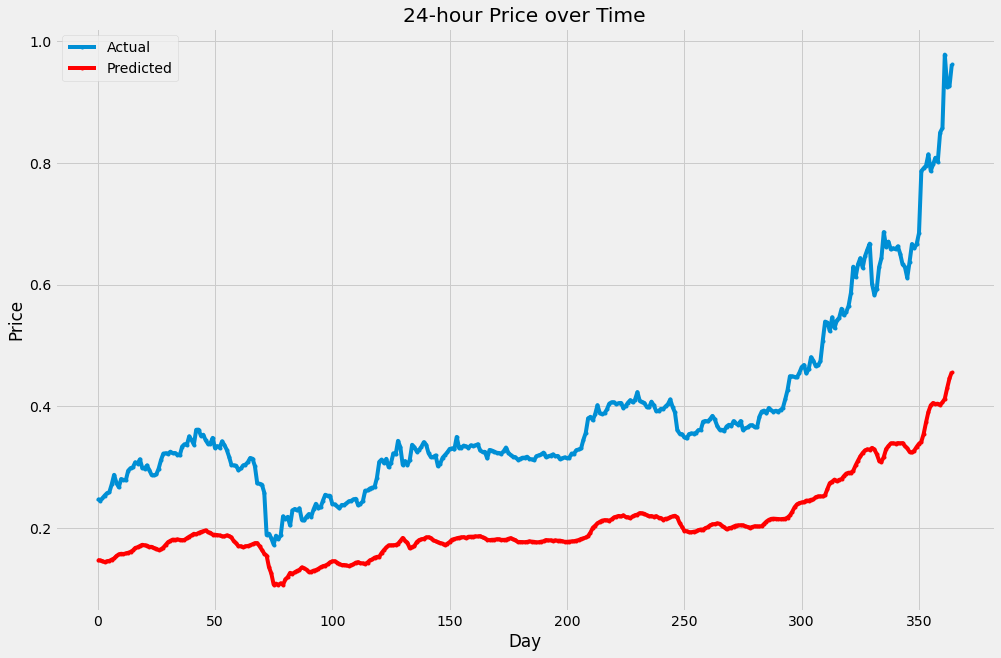

In [16]:
# Load best dense model on hourly data
hourDenseModel = keras.models.load_model('./HourDense1')

# Have the model predict on the validation set
predsHourDense = hourDenseModel.predict(XDense_test)
predsHourDense = [x[0] for x in predsHourDense]

# plot the results
plt.figure(figsize=(15,10))
plt.plot(YDense_test, marker='.', label="Actual")
plt.plot(predsHourDense, 'r', marker='.', label="Predicted")
plt.title('24-hour Price over Time')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()

In [12]:
# Function the simulates a buy and hold strategy
def naiveTrader2(money, prices):
    shares = money/prices[0]
    return shares*prices[-1]

# Function that simulates a trading strategy based on the model prediction
def allegedlySmartTrader2(money, prices, predictedPrices):
    assert len(prices) == len(predictedPrices)
    
    for i in range(len(prices)-1):
        if predictedPrices[i+1] > predictedPrices[i]:
            money = (money/prices[i])*prices[i+1]

    return money

# Simulate trading strategies
buyAndHold = naiveTrader2(100, YDense_test)
tradeOnModel = allegedlySmartTrader2(100, YDense_test, predsHourDense)

print('Buy and Hold Strategy: %.2f'%(buyAndHold))
print('Trading Strategy Based on Model: %.2f'%(tradeOnModel))        

Buy and Hold Strategy: 387.50
Trading Strategy Based on Model: 285.23


# Neural Network predicting 12 hours out #

In [18]:
# Create training and validation sets for a model that will make predicitons every 12 hours,
# i.e. the model goes through the data in 12-hour steps (but looking at 36 hour chunks of data)
# and makes predictions 12 hours out.
X=[]
Y=[]

for i in range(36,len(scaledData)-12, 12):
        X.append(np.array(scaledData[i-36:i+1]).flatten())
        Y.append(scaledData[i+12,1])
        
testSize = 365

XDense_train = np.array(X[:len(X)-testSize])
XDense_test = np.array(X[len(X)-testSize:])
YDense_train = np.array(Y[:len(Y)-testSize])
YDense_test = np.array(Y[len(Y)-testSize:])

assert (len(XDense_train)==len(YDense_train))
assert (len(XDense_test)==len(YDense_test))

print(XDense_train.shape)

# Create a Dense NN model to make predictions every 12 hours
hourDenseModel = keras.Sequential()

hourDenseModel.add(keras.layers.Input(XDense_train.shape[1]))
hourDenseModel.add(keras.layers.Dense(units = 2048, activation='relu'))
hourDenseModel.add(keras.layers.Dropout(0.4))
hourDenseModel.add(keras.layers.Dense(units = 2048, activation='relu'))
hourDenseModel.add(keras.layers.Dropout(0.4))
hourDenseModel.add(keras.layers.Dense(units = 1024, activation='relu'))
hourDenseModel.add(keras.layers.Dropout(0.4))
hourDenseModel.add(keras.layers.Dense(units = 512, activation='relu'))
hourDenseModel.add(keras.layers.Dropout(0.4))
hourDenseModel.add(keras.layers.Dense(units = 256, activation='relu'))
hourDenseModel.add(keras.layers.Dropout(0.4))
hourDenseModel.add(keras.layers.Dense(units = 128, activation='relu'))
hourDenseModel.add(keras.layers.Dropout(0.4))
hourDenseModel.add(keras.layers.Dense(units = 64, activation='relu'))
hourDenseModel.add(keras.layers.Dropout(0.4))
hourDenseModel.add(keras.layers.Dense(units=1))

hourDenseModel.compile(optimizer='adam', loss='mean_squared_error')

hourDenseModel.summary()



(5913, 222)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 2048)              456704    
_________________________________________________________________
dropout_7 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_8 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)  

In [127]:
saveModel = keras.callbacks.ModelCheckpoint(filepath ='./HourDense3', monitor='val_loss', mode='min', save_best_only=True)
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20)

#Train the model
hourDenseModel.fit(XDense_train, YDense_train, epochs=300,
           validation_data=(XDense_test, YDense_test), callbacks=[saveModel, earlyStopping])

Epoch 1/300
185/185 [==============================] - 8s 45ms/step - loss: 0.0094 - val_loss: 0.0693
Epoch 2/300
185/185 [==============================] - 12s 65ms/step - loss: 0.0047 - val_loss: 0.0568
Epoch 3/300
185/185 [==============================] - 6s 34ms/step - loss: 0.0043 - val_loss: 0.0791
Epoch 4/300
185/185 [==============================] - 6s 35ms/step - loss: 0.0034 - val_loss: 0.0794
Epoch 5/300
185/185 [==============================] - 6s 34ms/step - loss: 0.0038 - val_loss: 0.1039
Epoch 6/300
185/185 [==============================] - 6s 35ms/step - loss: 0.0033 - val_loss: 0.0960
Epoch 7/300
185/185 [==============================] - 6s 35ms/step - loss: 0.0031 - val_loss: 0.0852
Epoch 8/300
185/185 [==============================] - 6s 35ms/step - loss: 0.0029 - val_loss: 0.0916
Epoch 9/300
185/185 [==============================] - 7s 35ms/step - loss: 0.0025 - val_loss: 0.0742
Epoch 10/300
185/185 [==============================] - 6s 35ms/step - loss: 0.00

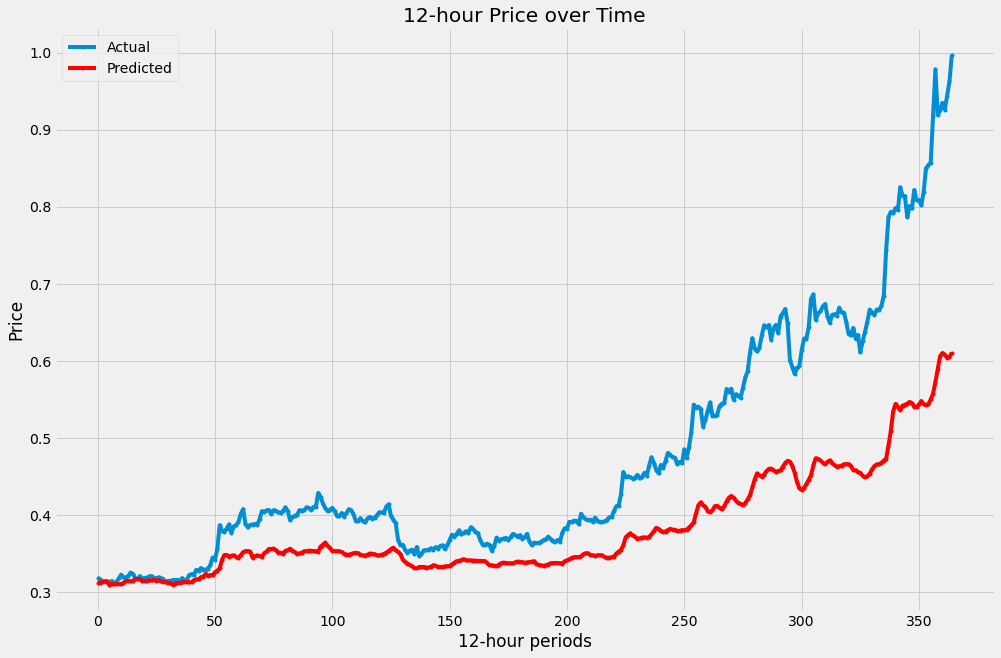

In [20]:
# Load the best model
hourDenseModel = keras.models.load_model('./HourDense3')

# Have the model predict on the validation set
predsHourDense = hourDenseModel.predict(XDense_test)
predsHourDense = [x[0] for x in predsHourDense]

#plot the results
plt.figure(figsize=(15,10))
plt.plot(YDense_test, marker='.', label="Actual")
plt.plot(predsHourDense, 'r', marker='.', label="Predicted")
plt.title('12-hour Price over Time')
plt.xlabel('12-hour periods')
plt.ylabel('Price')
plt.legend()

In [21]:
# Simulate trading strategies
buyAndHold = naiveTrader2(100, YDense_test)
tradeOnModel = allegedlySmartTrader2(100, YDense_test, predsHourDense)

print('Buy and Hold Strategy: %.2f'%(buyAndHold))
print('Trading Stragegy Based on Model: %.2f'%(tradeOnModel))      

Buy and Hold Strategy: 312.76
Trading Stragegy Based on Model: 206.61


# Neural Network predicting 1 hour out #

In [22]:
# Create training and validation sets for model that will go through the data in 6 hour steps and 
# make price predictions 1 hour out. 
X=[]
Y=[]

for i in range(12,len(scaledData)-1, 6):
        X.append(np.array(scaledData[i-12:i+1]).flatten())
        Y.append(scaledData[i+1,1])
        
testSize = 365

XDense_train = np.array(X[:len(X)-testSize])
XDense_test = np.array(X[len(X)-testSize:])
YDense_train = np.array(Y[:len(Y)-testSize])
YDense_test = np.array(Y[len(Y)-testSize:])

assert (len(XDense_train)==len(YDense_train))
assert (len(XDense_test)==len(YDense_test))


# build the Dense NN
hourDenseModel = keras.Sequential()

hourDenseModel.add(keras.layers.Input(XDense_train.shape[1]))
hourDenseModel.add(keras.layers.Dense(units = 2048, activation='relu'))
hourDenseModel.add(keras.layers.Dropout(0.4))
hourDenseModel.add(keras.layers.Dense(units = 2048, activation='relu'))
hourDenseModel.add(keras.layers.Dropout(0.4))
hourDenseModel.add(keras.layers.Dense(units = 1024, activation='relu'))
hourDenseModel.add(keras.layers.Dropout(0.4))
hourDenseModel.add(keras.layers.Dense(units = 512, activation='relu'))
hourDenseModel.add(keras.layers.Dropout(0.4))
hourDenseModel.add(keras.layers.Dense(units = 256, activation='relu'))
hourDenseModel.add(keras.layers.Dropout(0.4))
hourDenseModel.add(keras.layers.Dense(units = 128, activation='relu'))
hourDenseModel.add(keras.layers.Dropout(0.4))
hourDenseModel.add(keras.layers.Dense(units = 64, activation='relu'))
hourDenseModel.add(keras.layers.Dropout(0.4))
hourDenseModel.add(keras.layers.Dense(units=1))

hourDenseModel.compile(optimizer='adam', loss='mean_squared_error')

hourDenseModel.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 2048)              161792    
_________________________________________________________________
dropout_14 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dropout_15 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_16 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)              

In [140]:
saveModel = keras.callbacks.ModelCheckpoint(filepath ='./HourDense5', monitor='val_loss', mode='min', save_best_only=True)
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20)

#train the model
hourDenseModel.fit(XDense_train, YDense_train, epochs=300,
           validation_data=(XDense_test, YDense_test), callbacks=[saveModel, earlyStopping])

Epoch 1/300
382/382 [==============================] - 16s 41ms/step - loss: 0.0059 - val_loss: 0.0901
Epoch 2/300
382/382 [==============================] - 16s 42ms/step - loss: 0.0037 - val_loss: 0.0495
Epoch 3/300
382/382 [==============================] - 13s 35ms/step - loss: 0.0028 - val_loss: 0.0594
Epoch 4/300
382/382 [==============================] - 15s 41ms/step - loss: 0.0024 - val_loss: 0.0447
Epoch 5/300
382/382 [==============================] - 13s 35ms/step - loss: 0.0024 - val_loss: 0.0663
Epoch 6/300
382/382 [==============================] - 13s 35ms/step - loss: 0.0028 - val_loss: 0.0641
Epoch 7/300
382/382 [==============================] - 16s 41ms/step - loss: 0.0024 - val_loss: 0.0175
Epoch 8/300
382/382 [==============================] - 13s 35ms/step - loss: 0.0023 - val_loss: 0.0342
Epoch 9/300
382/382 [==============================] - 13s 35ms/step - loss: 0.0023 - val_loss: 0.0933
Epoch 10/300
382/382 [==============================] - 13s 35ms/step - l

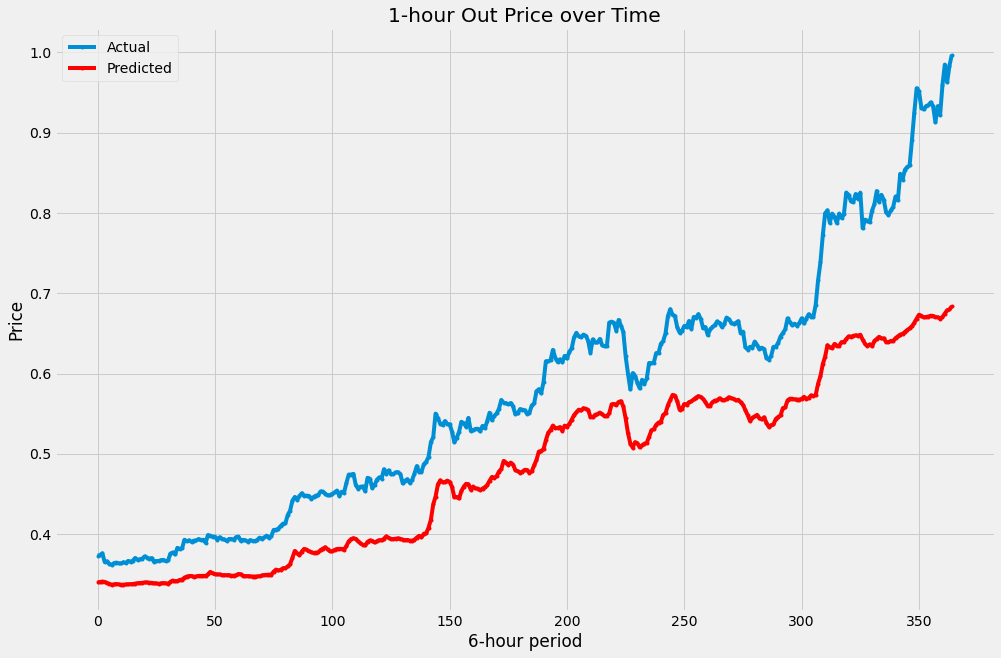

In [24]:
#load the best Model
hourDenseModel = keras.models.load_model('./HourDense5')

# Have model predict on validation set
predsHourDense = hourDenseModel.predict(XDense_test)
predsHourDense = [x[0] for x in predsHourDense]

# Plot the results
plt.figure(figsize=(15,10))
plt.plot(YDense_test, marker='.', label="Actual")
plt.plot(predsHourDense, 'r', marker='.', label="Predicted")
plt.title('1-hour Out Price over Time')
plt.xlabel('6-hour period')
plt.ylabel('Price')
plt.legend()

In [25]:
# Simulate trading strategies
buyAndHold = naiveTrader2(100, YDense_test)
tradeOnModel = allegedlySmartTrader2(100, YDense_test, predsHourDense)


print('Buy and Hold Strategy: %.2f'%(buyAndHold))
print('Trading Strategy Based on Model: %.2f'%(tradeOnModel))

      

Buy and Hold Strategy: 267.18
Trading Strategy Based on Model: 528.55
